In [58]:
# Importing required Libraries

import os
import re
import nltk
nltk.download('stopwords')
import plotly
import pickle
import time
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Loading the dataset

df_reviews = pd.read_csv("https://raw.githubusercontent.com/chirras/D3-Data/master/Data%20Files/winemag-data-130k-v2.csv")
df_reviews.drop('Unnamed: 0', axis=1, inplace=True)
df_reviews.head()


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [20]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [21]:
# Printing shape of the dataframe

df_reviews.shape


(129971, 13)

In [22]:
# Getting the unique values of country

df_reviews.country.unique()

array(['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', nan, 'Turkey', 'Czech Republic', 'Slovenia', 'Luxembourg',
       'Croatia', 'Georgia', 'Uruguay', 'England', 'Lebanon', 'Serbia',
       'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria',
       'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina',
       'Ukraine', 'Slovakia', 'Macedonia', 'China', 'Egypt'], dtype=object)

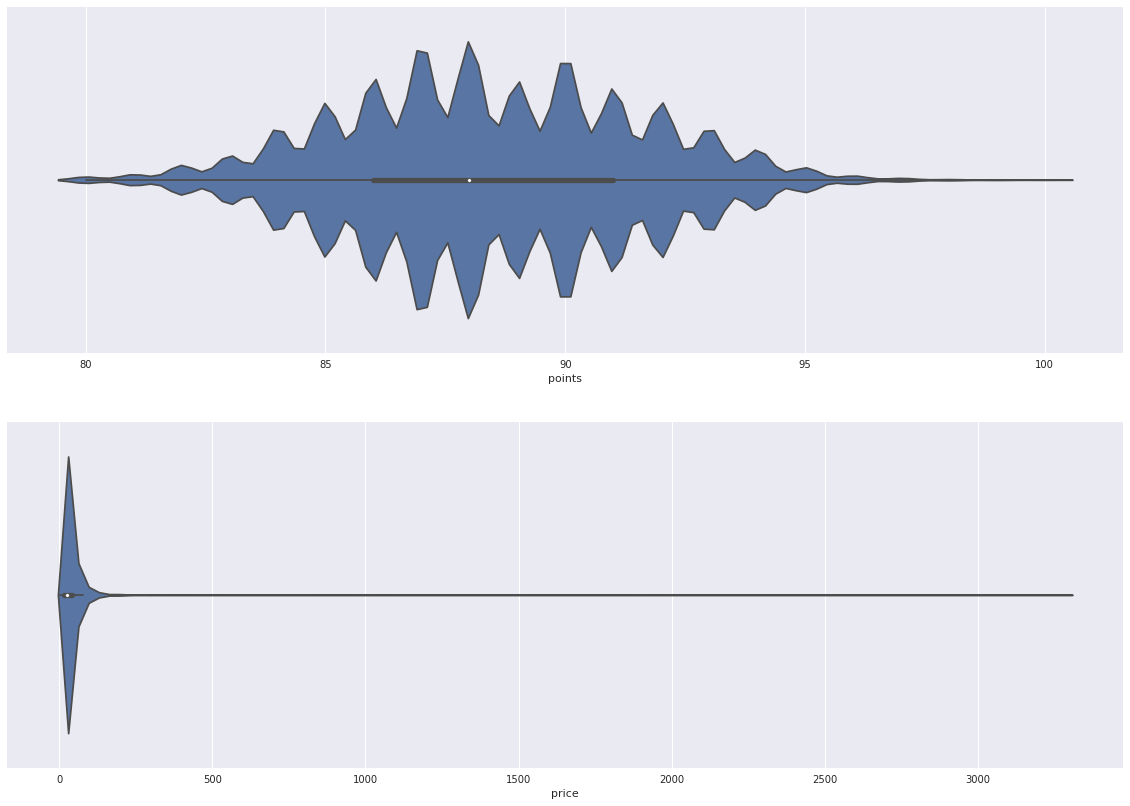

In [23]:
# Plotting the distribution of features using violin plots

plt.figure(figsize=(20,14))
plt.subplot(211)
sns.violinplot(df_reviews.points)

plt.subplot(212)
sns.violinplot(df_reviews.price)

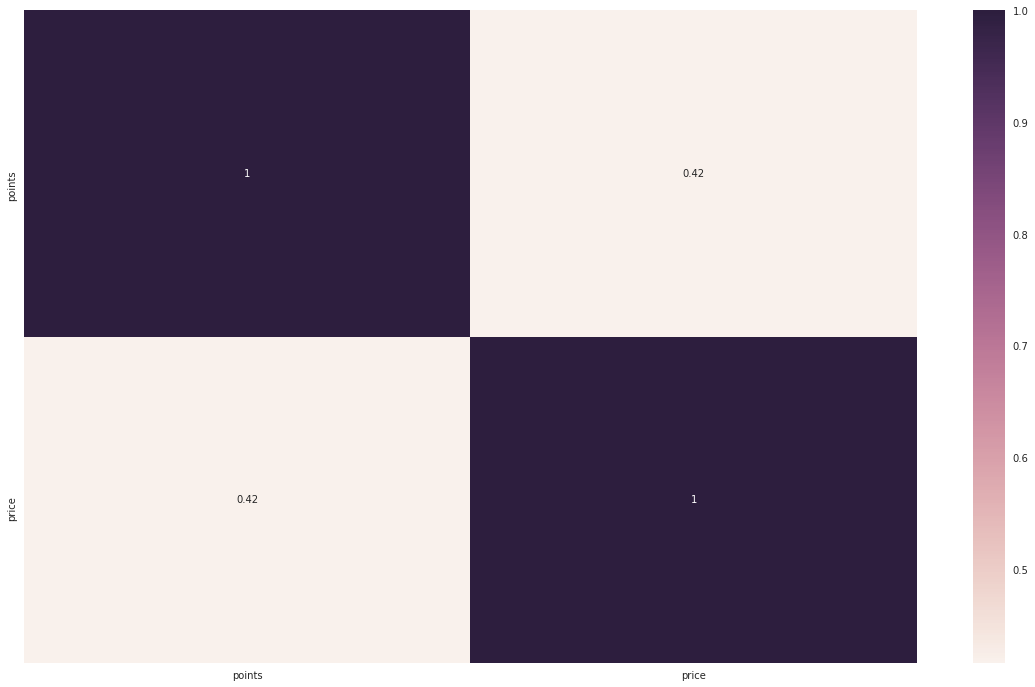

In [24]:
corrValues = df_reviews[['points','price']].corr()

# plot the heatmap
plt.figure(figsize=(20,12))
sns.heatmap(corrValues, annot=True)

In [25]:
# Printing number of unique values in each column

def printUniqueLen(df, column):
    print("Length of unique values in " + str(column) + ": " + str(len(df[column].unique())))
    
for col in list(df_reviews.columns):
    printUniqueLen(df_reviews, col)

Length of unique values in country: 44
Length of unique values in description: 119955
Length of unique values in designation: 37980
Length of unique values in points: 21
Length of unique values in price: 391
Length of unique values in province: 426
Length of unique values in region_1: 1230
Length of unique values in region_2: 18
Length of unique values in taster_name: 20
Length of unique values in taster_twitter_handle: 16
Length of unique values in title: 118840
Length of unique values in variety: 708
Length of unique values in winery: 16757


In [26]:
df_reviews.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [27]:
%%time

## Preprocessing the text data for feature 'description'

# Using regex to filter the non alphabet characters
stopWords =  stopwords.words('english')
df_reviews.description = [re.sub('[^a-zA-Z]', ' ', text) for text in df_reviews.description]

# Converting description to lowercase
df_reviews.description = [text.lower() for text in df_reviews.description]
# Spliting the description to words
df_reviews.description = [text.split() for text in df_reviews.description]
# Removing the stopwords
df_reviews.description = [[word for word in text if word not in stopWords] for text in df_reviews.description]
# Stemming the words and joining them to sentence 
pStem = PorterStemmer()
df_reviews.description = [" ".join([pStem.stem(word) for word in text]) for text in df_reviews.description]


CPU times: user 1min 20s, sys: 88 ms, total: 1min 20s
Wall time: 1min 20s


In [28]:
%%time

## One-Hot encoding for categorical Features 

# country
df_reviews[list(pd.get_dummies(df_reviews.country).columns)] = pd.get_dummies(df_reviews.country)

# taster_name
df_reviews[list(pd.get_dummies(df_reviews.taster_name).columns)] = pd.get_dummies(df_reviews.taster_name)

# taster_twitter_handle
df_reviews[list(pd.get_dummies(df_reviews.taster_twitter_handle).columns)] = pd.get_dummies(df_reviews.taster_twitter_handle)

# province
df_reviews[list(pd.get_dummies(df_reviews.province).columns)] = pd.get_dummies(df_reviews.province)

# region_1
df_reviews[list(pd.get_dummies(df_reviews.region_1).columns)] = pd.get_dummies(df_reviews.region_1)

# region_2
df_reviews[list(pd.get_dummies(df_reviews.region_2).columns)] = pd.get_dummies(df_reviews.region_2)

# variety
df_reviews[list(pd.get_dummies(df_reviews.variety).columns)] = pd.get_dummies(df_reviews.variety)


## Dropping the columns
df_reviews.drop(['country','taster_name','taster_twitter_handle','province','region_1','region_2', 'variety'], axis=1, inplace=True)


CPU times: user 5.49 s, sys: 5.58 s, total: 11.1 s
Wall time: 11.1 s


In [29]:

## Categorical fields with more than 10,000 unique categories
# Capturing the number of characters for fields designation, title, winery

df_reviews['designationLen'] = [len(str(text)) for text in df_reviews['designation']]
df_reviews['titleLen'] = [len(str(text)) for text in df_reviews['title']]
df_reviews['wineryLen'] = [len(str(text)) for text in df_reviews['winery']]


## Dropping the columns
df_reviews.drop(['designation','title','winery'], axis=1, inplace=True)


In [30]:
## Dividing the train and test datasets
# Split data randomly into train and test datasets with a ratio of 80:20.

train, test = train_test_split(df_reviews, test_size=0.2, random_state=34)


In [31]:
# Printing the shape of train and test datasets

train.shape, test.shape


((103976, 2364), (25995, 2364))

In [32]:
# Using tfidf vectorizer to extract vectors from text

tfidfVec = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,1), max_df=0.85)
tfidfVec.fit(df_reviews.description)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.85, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [33]:
%%time

# Using the fit tfidf vectorizer to transform 'description' into vectors for train data

trainVect = tfidfVec.transform(train.description)
train[pd.DataFrame(trainVect.toarray()).columns] = pd.DataFrame(trainVect.toarray())


CPU times: user 10.2 s, sys: 6.97 s, total: 17.2 s
Wall time: 17.2 s


In [34]:
# Printing the shape of the dataframe after vectorizing the description

train.shape


(103976, 3364)

In [35]:
# Dorpping the description column from train dataset

train.drop(['description'], axis=1, inplace=True)


In [36]:
# Dividing the target and features for train dataset

X_train, Y_train = train.drop(['points'], axis=1), train.points



In [37]:
# Printing the shapes

X_train.shape, Y_train.shape



((103976, 3362), (103976,))

In [38]:
# Normalizing the train data

scaler = preprocessing.MinMaxScaler()

X_train[['price','designationLen','titleLen','wineryLen']] = scaler.fit_transform(X_train[['price','designationLen','titleLen','wineryLen']].fillna(0))


#### Model Selection

    1. Linear Regression with Lasso Regularization
    2. Random Forest
    3. XGBoost
    
    

In [39]:
%%time

# Linear Regression with Lasso regularization

modelLasso = Lasso(alpha=0.3)
modelLasso.fit(X_train.fillna(0), Y_train)


CPU times: user 12.4 s, sys: 8.59 s, total: 21 s
Wall time: 20 s


In [40]:
%%time

# Random Forest

modelRF = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1)
modelRF.fit(X_train.fillna(0), Y_train)


CPU times: user 20min 55s, sys: 2.79 s, total: 20min 58s
Wall time: 2min 45s


In [41]:
%%time 

# XGBoost

modelXG = XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=100, n_jobs=-1)
modelXG.fit(X_train, Y_train)


CPU times: user 33min 49s, sys: 9.63 s, total: 33min 58s
Wall time: 4min 31s


In [42]:
# Using the fit tfidf vectorizer to transform 'description' into vectors for test data

testVect = tfidfVec.transform(test.description)
test[pd.DataFrame(testVect.toarray()).columns] = pd.DataFrame(testVect.toarray())


In [43]:
# Printing the shape of the dataframe after vectorizing the description

test.shape


(25995, 3364)

In [44]:
# Dorpping the description column from train dataset

test.drop(['description'], axis=1, inplace=True)


In [45]:
# Dividing the target and features for test dataset

X_test, Y_test = test.drop(['points'], axis=1), test.points


In [46]:
# Normalizing the test data

X_test[['price','designationLen','titleLen','wineryLen']] = scaler.transform(X_test[['price','designationLen','titleLen','wineryLen']].fillna(0))


In [47]:
# Prediction on test data using Linear Regression

y_pred_lr = modelLasso.predict(X_test.fillna(0))


In [48]:
## Evaluation Metrics 

# RMSE
print("RMSE of Linear Regression Model: " + str(np.sqrt(metrics.mean_squared_error(Y_test, y_pred_lr))))


RMSE of Linear Regression Model: 3.04378716073


In [49]:
# Prediction on test data using RF

y_pred_rf = modelRF.predict(X_test.fillna(0))


In [50]:
## Evaluation Metrics 

# Variance Score
print("Explained Variance of Random Forest: " + str(metrics.explained_variance_score(Y_test, y_pred_rf)))

# RMSE
print("RMSE of Random Forest: " + str(np.sqrt(metrics.mean_squared_error(Y_test, y_pred_rf))))


Explained Variance of Random Forest: 0.374218583623
RMSE of Random Forest: 2.40787356219


In [51]:
# Prediction on test data using XGBoost

y_pred_xg = modelXG.predict(X_test)


In [52]:
## Evaluation Metrics 

# Variance Score
print("Explained Variance of XGBoost: " + str(metrics.explained_variance_score(Y_test, y_pred_xg)))

# RMSE
print("RMSE of XGBoost: " + str(np.sqrt(metrics.mean_squared_error(Y_test, y_pred_xg))))


Explained Variance of XGBoost: 0.434192738671
RMSE of XGBoost: 2.3512862328


<Figure size 432x288 with 0 Axes>

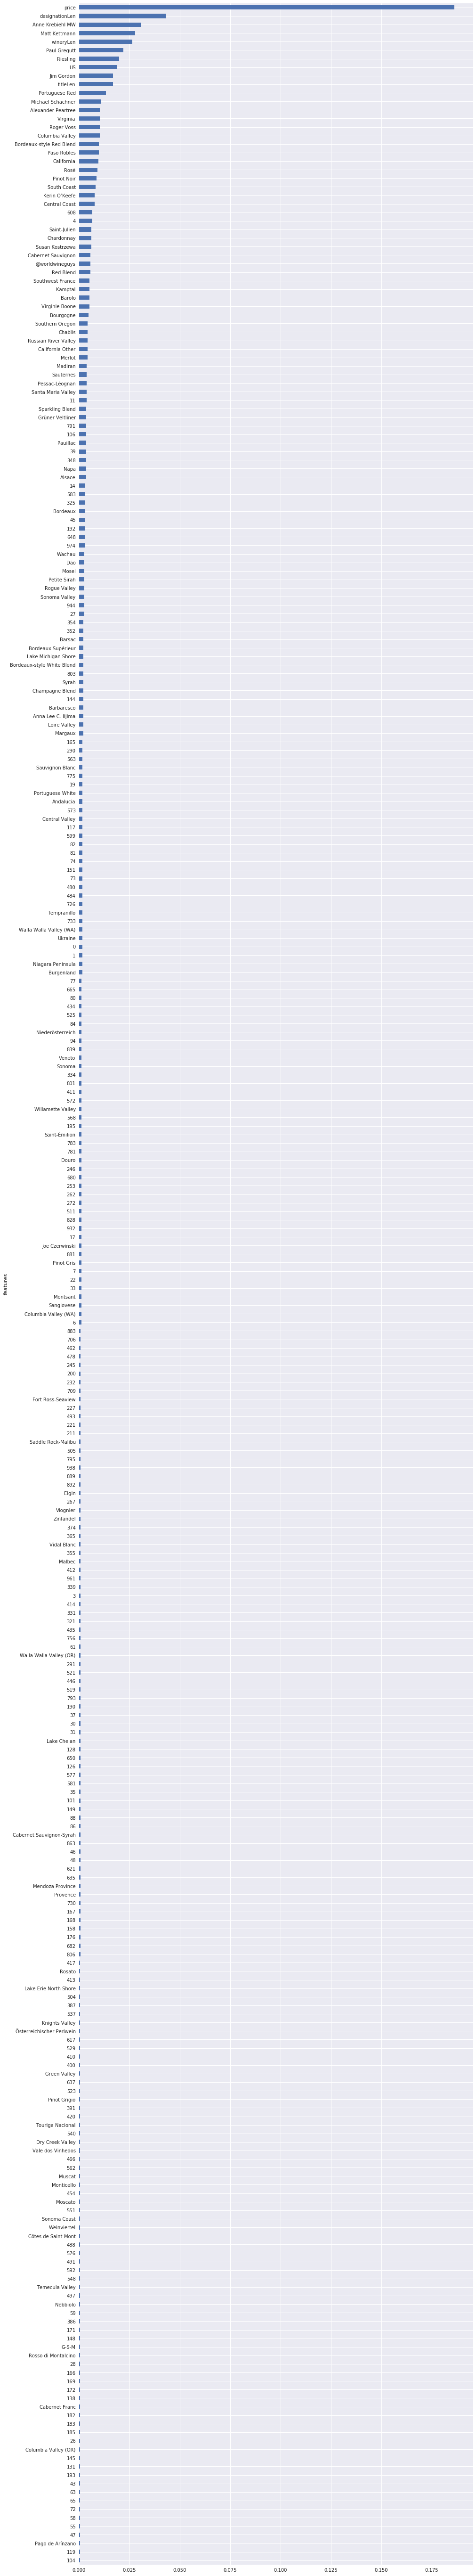

In [53]:
# Plotting feature importance

df_featImp = pd.DataFrame({'features': X_train.columns, 'importance': modelXG.feature_importances_})
df_featImp = df_featImp.sort_values('importance').reset_index(drop=True).tail(300)

plt.figure()
df_featImp.plot(kind='barh', x='features', y='importance', legend=False, figsize=(15,100))



In [54]:
## Filtering the Features based on Feature Importance
# As most of the features doesn't play any role in prediction, top 300 features are taken into consideration.

impFeat = list(df_featImp.sort_values(['importance'], ascending=False).features)


In [61]:
%%time

# Tuning Hyperparameter for Lasso
paramsL = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0]}

# Defining the model
LassoGS = Lasso()

# Defining the grid search 
gridL = GridSearchCV(LassoGS, paramsL, cv=10, n_jobs=-1)
gridL.fit(X_train[impFeat].fillna(0), Y_train)


CPU times: user 38.4 s, sys: 1.77 s, total: 40.2 s
Wall time: 12min 11s


In [63]:
%%time

# Tuning Hyperparameter for Lasso
paramsRF = {'max_depth': [3,4,5], 'n_estimators': [100, 200, 300]}

# Defining the model
modelRF = RandomForestRegressor(n_jobs=-1)

# Defining the grid search 
gridRF = GridSearchCV(modelRF, paramsRF, cv=10, n_jobs=-1)
gridRF.fit(X_train[impFeat].fillna(0), Y_train)


CPU times: user 9min 51s, sys: 2.25 s, total: 9min 53s
Wall time: 53min 54s


In [55]:
%%time

## Tuning Hyperparameters XGBoost

# Defining the parameters
params = {'max_depth': [3,4,5], 'learning_rate': [0.03, 0.05, 0.1, 0.5]}

# Defining the model
xgbGS = XGBRegressor(nthread=-1) 

# Defining the grid search 
grid = GridSearchCV(xgbGS, params, cv=10, n_jobs=-1)
grid.fit(X_train[impFeat], Y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [65]:
# cv_validation_scores for XGBoost

grid_cv_scores_lasso = [list(result.cv_validation_scores) for result in gridL.grid_scores_]
grid_cv_scores_RF = [list(result.cv_validation_scores) for result in gridRF.grid_scores_]
grid_cv_scores_XG = [list(result.cv_validation_scores) for result in grid.grid_scores_]


In [77]:
# Parameter visualization for Lasso

lassoR2Score = [y for x in grid_cv_scores_lasso for y in x]
temp = [list(itertools.repeat(i, 10)) for i in [1, 0.1, 0.01, 0.001, 0.0001, 0]]
alpha = [y for x in temp for y in x]

df_lasso = pd.DataFrame({'lassoR2Score': lassoR2Score, 'alpha': alpha})


In [78]:
# Plot for Lasso

trace0 = go.Scatter(
    x = df_lasso.lassoR2Score,
    y = df_lasso.alpha,
    mode = 'markers+lines',
    marker=dict(
        size=10,
        color = df_lasso.alpha,
        colorbar=dict(title='Value of Alpha'),
        showscale=True
    )
)

data = [trace0]

layout= go.Layout(
    legend=dict(
        traceorder='normal',
        font=dict(
            size=12,
            color='#000'
        )
    ),
    title= 'Performance of Lasso for different Alpha',
    xaxis= dict(
        title= 'Value of Alpha'
    ),
    yaxis=dict(
        title= 'R2-Score'
    )
)  

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)


In [90]:
gridRF.grid_scores_

[mean: 0.33435, std: 0.00828, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.33423, std: 0.00839, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.33426, std: 0.00832, params: {'max_depth': 3, 'n_estimators': 300},
 mean: 0.36278, std: 0.00728, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.36277, std: 0.00735, params: {'max_depth': 4, 'n_estimators': 200},
 mean: 0.36281, std: 0.00721, params: {'max_depth': 4, 'n_estimators': 300},
 mean: 0.37854, std: 0.00681, params: {'max_depth': 5, 'n_estimators': 100},
 mean: 0.37856, std: 0.00680, params: {'max_depth': 5, 'n_estimators': 200},
 mean: 0.37859, std: 0.00687, params: {'max_depth': 5, 'n_estimators': 300}]

In [103]:
# Parameter visualization for Random Forest

maxDepth = [y for x in [list(itertools.repeat(i, 30)) for i in [3,4,5]] for y in x]
nEstimators = [y for x in [list(itertools.repeat(i, 10)) for i in [100,200,300]] for y in x]
nEst = list()
nEst.extend(nEstimators)
nEst.extend(nEstimators)
nEst.extend(nEstimators)

RFR2Score = [y for x in grid_cv_scores_RF for y in x]

df_rf = pd.DataFrame({'maxDepth': maxDepth, 'nEstimators': nEst, 'RFR2Score': RFR2Score})


In [104]:
# Scatter plot to display the result of Random Forest 

trace0 = go.Scatter(
    x = df_rf.index,
    y = df_rf.RFR2Score,
    mode = 'markers+lines',
    marker=dict(
        size=df_rf.nEstimators/15,
        color = df_rf.maxDepth
    )
)

data = [trace0]

layout= go.Layout(
    legend=dict(
        traceorder='normal',
        font=dict(
            size=12,
            color='#000'
        )
    ),
    title= 'Performance of Random Forest',
    xaxis= dict(
        title= 'Number of runs'
    ),
    yaxis=dict(
        title= 'R2-Score'
    )
)  

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)

In [107]:
# Parameter visualization for Random Forest

learningRate = [y for x in [list(itertools.repeat(i, 30)) for i in [0.03, 0.05, 0.1, 0.5]] for y in x]
maxDepth = [y for x in [list(itertools.repeat(i, 10)) for i in [3,4,5]] for y in x]
maxDep = list()
maxDep.extend(maxDepth)
maxDep.extend(maxDepth)
maxDep.extend(maxDepth)
maxDep.extend(maxDepth)

RFR2Score = [y for x in grid_cv_scores_XG for y in x]

df_xg = pd.DataFrame({'maxDepth': maxDep, 'learningRate': learningRate, 'RFR2Score': RFR2Score})


In [108]:
# Hyperparameter plot to display the result of XGBoost

trace0 = go.Scatter(
    x = df_xg.index,
    y = df_xg.RFR2Score,
    mode = 'markers+lines',
    marker=dict(
        size=df_xg.maxDepth*5,
        color = df_xg.learningRate
    )
)

data = [trace0]

layout= go.Layout(
    legend=dict(
        traceorder='normal',
        font=dict(
            size=12,
            color='#000'
        )
    ),
    title= 'Performance of XGBoost',
    xaxis= dict(
        title= 'Number of runs'
    ),
    yaxis=dict(
        title= 'R2-Score'
    )
)  

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)